In [390]:
import torch
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from gtda.graphs import KNeighborsGraph
import itertools
from utils import GraphRNN_dataset, GraphRNN_DataSampler
import random

from importlib import reload
import matplotlib.pyplot as plt

from preprocessor import Preprocessor
from preprocessor import draw_network
from preprocessor import get_adj_from_plot

from preprocessor_final_data import Preprocessor
from preprocessor_final_data import draw_network
from preprocessor_final_data import get_adj_from_plot

print("Gathering data...")
flow_dataset = "../data/daily_county2county_2019_01_01.csv"
epi_dataset = "../data_epi/epidemiology.csv"
epi_dates = ["2020-06-09", "2020-06-10", "2020-06-11", "2020-06-12",
             "2020-06-13", "2020-06-14", "2020-06-15", "2020-06-16",
             "2020-06-17", "2020-06-18", "2020-06-19", "2020-06-20",
             "2020-06-21", "2020-06-22", "2020-06-23", "2020-06-24",
                "2020-06-25", "2020-06-26", "2020-06-27", "2020-06-28",
                "2020-06-29", "2020-06-30", "2020-07-01", "2020-07-02",
                "2020-07-03", "2020-07-04", "2020-07-05", "2020-07-06",
                "2020-07-07", "2020-07-08", "2020-07-09", "2020-07-10",
                "2020-07-11", "2020-07-12", "2020-07-13", "2020-07-14",
                "2020-07-15", "2020-07-16", "2020-07-17", "2020-07-18",
                "2020-07-19", "2020-07-20", "2020-07-21", "2020-07-22",
                "2020-07-23", "2020-07-24", "2020-07-25", "2020-07-26",
                "2020-07-27", "2020-07-28", "2020-07-29", "2020-07-30"
             ]

epi_dates_medium = [
    "2020-06-09", "2020-06-10", "2020-06-11", "2020-06-12",
    "2020-06-13", "2020-06-14", "2020-06-15", "2020-06-16",
    "2020-06-17", "2020-06-18", "2020-06-19", "2020-06-20",
    "2020-06-21", "2020-06-22", "2020-06-23", "2020-06-24",
    "2020-06-25", "2020-06-26", "2020-06-27", "2020-06-28",
    "2020-06-29", "2020-06-30", "2020-07-01", "2020-07-02",
    "2020-07-03", "2020-07-04", "2020-07-05", "2020-07-06",
    "2020-07-07", "2020-07-08", "2020-07-09", "2020-07-10",
    "2020-07-11", "2020-07-12", "2020-07-13", "2020-07-14",
    "2020-07-15", "2020-07-16", "2020-07-17", "2020-07-18",
    "2020-07-19", "2020-07-20", "2020-07-21", "2020-07-22",
    "2020-07-23", "2020-07-24", "2020-07-25", "2020-07-26",
    "2020-07-27", "2020-07-28", "2020-07-29", "2020-07-30",
    "2020-07-31", "2020-08-01", "2020-08-02", "2020-08-03",
    "2020-08-04", "2020-08-05", "2020-08-06", "2020-08-07",
    "2020-08-08", "2020-08-09", "2020-08-10", "2020-08-11",
    "2020-08-12", "2020-08-13", "2020-08-14", "2020-08-15",
    "2020-08-16", "2020-08-17", "2020-08-18", "2020-08-19",
    "2020-08-20", "2020-08-21", "2020-08-22", "2020-08-23",
    "2020-08-24", "2020-08-25", "2020-08-26", "2020-08-27",
    "2020-08-28", "2020-08-29", "2020-08-30", "2020-08-31",
    "2020-09-01", "2020-09-02", "2020-09-03", "2020-09-04",
    "2020-09-05", "2020-09-06", "2020-09-07", "2020-09-08",
    "2020-09-09", "2020-09-10", "2020-09-11", "2020-09-12",
    "2020-09-13", "2020-09-14", "2020-09-15", "2020-09-16",
    "2020-09-17", "2020-09-18", "2020-09-19", "2020-09-20",
    "2020-09-21", "2020-09-22", "2020-09-23", "2020-09-24",
    "2020-09-25", "2020-09-26", "2020-09-27", "2020-09-28",
    "2020-09-29", "2020-09-30"
]

epi_dates_large = [
    "2020-06-01", "2020-06-02", "2020-06-03", "2020-06-04", 
    "2020-06-05", "2020-06-06", "2020-06-07", "2020-06-08",
    "2020-06-09", "2020-06-10", "2020-06-11", "2020-06-12",
    "2020-06-13", "2020-06-14", "2020-06-15", "2020-06-16",
    "2020-06-17", "2020-06-18", "2020-06-19", "2020-06-20",
    "2020-06-21", "2020-06-22", "2020-06-23", "2020-06-24",
    "2020-06-25", "2020-06-26", "2020-06-27", "2020-06-28",
    "2020-06-29", "2020-06-30", "2020-07-01", "2020-07-02",
    "2020-07-03", "2020-07-04", "2020-07-05", "2020-07-06",
    "2020-07-07", "2020-07-08", "2020-07-09", "2020-07-10",
    "2020-07-11", "2020-07-12", "2020-07-13", "2020-07-14",
    "2020-07-15", "2020-07-16", "2020-07-17", "2020-07-18",
    "2020-07-19", "2020-07-20", "2020-07-21", "2020-07-22",
    "2020-07-23", "2020-07-24", "2020-07-25", "2020-07-26",
    "2020-07-27", "2020-07-28", "2020-07-29", "2020-07-30",
    "2020-07-31", "2020-08-01", "2020-08-02", "2020-08-03",
    "2020-08-04", "2020-08-05", "2020-08-06", "2020-08-07",
    "2020-08-08", "2020-08-09", "2020-08-10", "2020-08-11",
    "2020-08-12", "2020-08-13", "2020-08-14", "2020-08-15",
    "2020-08-16", "2020-08-17", "2020-08-18", "2020-08-19",
    "2020-08-20", "2020-08-21", "2020-08-22", "2020-08-23",
    "2020-08-24", "2020-08-25", "2020-08-26", "2020-08-27",
    "2020-08-28", "2020-08-29", "2020-08-30", "2020-08-31",
    "2020-09-01", "2020-09-02", "2020-09-03", "2020-09-04",
    "2020-09-05", "2020-09-06", "2020-09-07", "2020-09-08",
    "2020-09-09", "2020-09-10", "2020-09-11", "2020-09-12",
    "2020-09-13", "2020-09-14", "2020-09-15", "2020-09-16",
    "2020-09-17", "2020-09-18", "2020-09-19", "2020-09-20",
    "2020-09-21", "2020-09-22", "2020-09-23", "2020-09-24",
    "2020-09-25", "2020-09-26", "2020-09-27", "2020-09-28",
    "2020-09-29", "2020-09-30", "2020-10-01", "2020-10-02",
    "2020-10-03", "2020-10-04", "2020-10-05", "2020-10-06",
    "2020-10-07", "2020-10-08", "2020-10-09", "2020-10-10",
    "2020-10-11", "2020-10-12", "2020-10-13", "2020-10-14",
    "2020-10-15", "2020-10-16", "2020-10-17", "2020-10-18",
    "2020-10-19", "2020-10-20", "2020-10-21", "2020-10-22",
    "2020-10-23", "2020-10-24", "2020-10-25", "2020-10-26",
    "2020-10-27", "2020-10-28", "2020-10-29", "2020-10-30",
    "2020-10-31", "2020-11-01", "2020-11-02", "2020-11-03",
    "2020-11-04", "2020-11-05", "2020-11-06", "2020-11-07",
    "2020-11-08", "2020-11-09", "2020-11-10", "2020-11-11",
    "2020-11-12", "2020-11-13", "2020-11-14", "2020-11-15",
    "2020-11-16", "2020-11-17", "2020-11-18", "2020-11-19",
    "2020-11-20", "2020-11-21", "2020-11-22", "2020-11-23",
    "2020-11-24", "2020-11-25", "2020-11-26", "2020-11-27",
    "2020-11-28", "2020-11-29", "2020-11-30", "2020-12-01",
    "2020-12-02", "2020-12-03", "2020-12-04", "2020-12-05",
    "2020-12-06", "2020-12-07", "2020-12-08", "2020-12-09",
    "2020-12-10", "2020-12-11", "2020-12-12", "2020-12-13",
    "2020-12-14", "2020-12-15", "2020-12-16", "2020-12-17",
    "2020-12-18", "2020-12-19", "2020-12-20", "2020-12-21",
    "2020-12-22", "2020-12-23", "2020-12-24", "2020-12-25",
    "2020-12-26", "2020-12-27", "2020-12-28", "2020-12-29",
    "2020-12-30", "2020-12-31"
]

epi_dates_smaller = ["2020-06-09", "2020-06-10", "2020-06-11", "2020-06-12",
             "2020-06-13", "2020-06-14", "2020-06-15", "2020-06-16",
             "2020-06-17", "2020-06-18", "2020-06-19", "2020-06-20",
             ]

epi_dates_one_sample = ["2020-06-09", "2020-06-10", "2020-06-11", "2020-06-12",
             "2020-06-13", "2020-06-14", "2020-06-15"] # for testing
epi_dates_pred_one_sample = ["2020-06-16"] # for testing

Gathering data...


Preprocessing data...
/Users/anja/Documents/Documents - Mac/Delft/Q4/GraphsML/final/code_v2/GraphML/ClassicalModels
Number of duplicate values in graph_kronecker_whole_df:  0
Check: First dataframe in graph_kronecker_whole_df:  geoid_o                                      1001
geoid_d                                   1001021
lng_o                                  -86.642757
lat_o                                   32.534921
lng_d                                  -86.718814
lat_d                                   32.847853
date                                   2019-01-01
visitor_flows                            0.463154
pop_flows                                0.550704
population1                             -0.017196
population2                              0.021202
weather1                                 -0.36587
weather2                                -0.038436
cumulative_confirmed                     0.013195
cumulative_deceased                      0.208404
new_deceased          

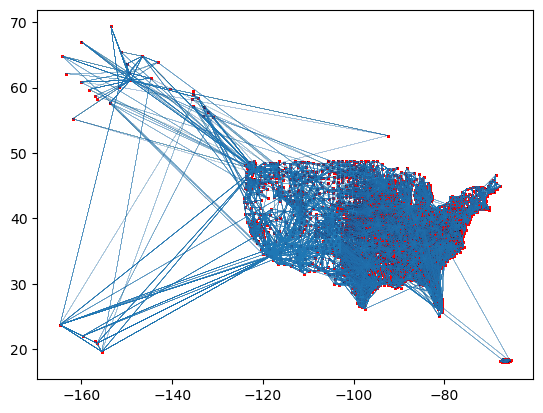

In [392]:
# THIS IS WITH THE NEW PREPROCESSOR FILE (PREPROCESSOR_FINAL_DATA.PY)
import preprocessor_final_data 

print("Preprocessing data...")

# Preprocess the data
input_hor = 7   # test now with smaller input horizon
pred_hor = 1    # test now with smaller prediction horizon
train_perc, test_perc = 0.8, 0.2

# Preprocess the data
import os
print(os.getcwd())
locations_data = "../final_data/locations_data_unique.npy"
epi_dataset = "../final_data/X_normalized.npy"
preproc = preprocessor_final_data.Preprocessor(flow_dataset, epi_dataset, locations_data)

graph_kronecker_whole_df = preproc.combined_manual_kronecker() # makes the pandas df from the kronecker data

# check for duplicate values in graph_kronecker_whole_df
print("Number of duplicate values in graph_kronecker_whole_df: ", graph_kronecker_whole_df.duplicated().sum())

# print first dataframe in graph_kronecker_whole_df, check if the data is getting pulled correctly
print("Check: First dataframe in graph_kronecker_whole_df: ", graph_kronecker_whole_df.iloc[0])

# count how many entries have geoids are below 1000000 assuming the dataframe is sorted by geoid
count = 0
list_of_geoids = []
for i in range(len(graph_kronecker_whole_df)):
    cur = graph_kronecker_whole_df.iloc[i]['geoid_o']
    if cur < 1000000:
        if cur not in list_of_geoids:
            list_of_geoids.append(cur)
        count += 1
    if i > 200000:
        break

# list_of_geoids = list(set(list_of_geoids))  # Convert to set and back to list

print("Number of nodes on first day is, ", len(list_of_geoids))

number_nodes_per_day = len(list_of_geoids)


# count how many entries have geoid_o above 1000000 and below 2000000 assuming the dataframe is sorted by geoid
count = 0
list_of_geoids = []
for i in range(len(graph_kronecker_whole_df)):
    cur = graph_kronecker_whole_df.iloc[i]['geoid_o']
    if cur < 2000000 and cur >= 1000000:
        if cur not in list_of_geoids:
            list_of_geoids.append(cur)
        count += 1
    if i > 300000:
        break

print("Number of nodes on second day is, ", len(list_of_geoids))

# print last dataframe in graph_kronecker_whole_df, check if the data is getting pulled correctly
print("Check: Last dataframe in graph_kronecker_whole_df: ", graph_kronecker_whole_df.iloc[-1])

# print("Drawing the network ...")
draw_network(graph_kronecker_whole_df)

In [419]:
# NEWER VERSION

from preprocessor_final_data import get_adj_from_plot
from preprocessor_final_data import draw_network

print("Getting the adjacency matrix..")
adj_kronecker_whole = get_adj_from_plot(graph_kronecker_whole_df)

# Check that the dimensions of the adj are correct
print("Check: Dimsensions of adj: ", adj_kronecker_whole.shape)
print("Check: the number of days is: ", adj_kronecker_whole.shape[0]/(number_nodes_per_day))
print("(ERROR) Check: Shape of adj % num nodes per day, should be 0: ", adj_kronecker_whole.shape[0] % (number_nodes_per_day))




print("Getting the training graph signal...")
# do it first only with cumulative_confirmed
tr_epi = preproc.set_timestep_offset_epi_dataset(from_timestep=0).get_epi_dataset() # will get the epi info for the entire dataset, the entire kronecker, then later we index per training example and pred
print(len(tr_epi)) # working, should be 30
train_graph_sig = {}
for data in tr_epi:
    for geoid in data.geoid_o:
        if geoid not in train_graph_sig:
            train_graph_sig[geoid] = {
                'weather1': [],
                'weather2': [],
                'cumulative_confirmed': [],
                'cumulative_deceased': [],
                'new_deceased': [],
                'cumulative_persons_fully_vaccinated': [],
                'new_persons_fully_vaccinated': []
            }
        
        # Append the values to the corresponding lists
        train_graph_sig[geoid]['weather1'].append(data.weather1)
        train_graph_sig[geoid]['weather2'].append(data.weather2)
        train_graph_sig[geoid]['cumulative_confirmed'].append(data.cumulative_confirmed)
        train_graph_sig[geoid]['cumulative_deceased'].append(data.cumulative_deceased)
        train_graph_sig[geoid]['new_deceased'].append(data.new_deceased)
        train_graph_sig[geoid]['cumulative_persons_fully_vaccinated'].append(data.cumulative_persons_fully_vaccinated)
        train_graph_sig[geoid]['new_persons_fully_vaccinated'].append(data.new_persons_fully_vaccinated)
print("Check: Should be number of nodes per day * number of days", len(train_graph_sig))  # working

# sort train_graph_sig by geoid_o
train_graph_sig = dict(sorted(train_graph_sig.items(), key=lambda item: item[0]))

# print the first element of train_graph_sig, check if the data is getting pulled correctly
# print("Check: First element in train_graph_sig: ", {k: train_graph_sig[k] for k in list(train_graph_sig)[:1]})


# Collect all feature lists into separate arrays for normalization
weather1_values = [train_graph_sig[geoid]['weather1'] for geoid in train_graph_sig]
weather2_values = [train_graph_sig[geoid]['weather2'] for geoid in train_graph_sig]
cumulative_confirmed_values = [train_graph_sig[geoid]['cumulative_confirmed'] for geoid in train_graph_sig]
cumulative_deceased_values = [train_graph_sig[geoid]['cumulative_deceased'] for geoid in train_graph_sig]
new_deceased_values = [train_graph_sig[geoid]['new_deceased'] for geoid in train_graph_sig]
cumulative_persons_fully_vaccinated_values = [train_graph_sig[geoid]['cumulative_persons_fully_vaccinated'] for geoid in train_graph_sig]
new_persons_fully_vaccinated_values = [train_graph_sig[geoid]['new_persons_fully_vaccinated'] for geoid in train_graph_sig]


mean_weather1 = np.mean(weather1_values)
std_weather1 = np.std(weather1_values)

mean_weather2 = np.mean(weather2_values)
std_weather2 = np.std(weather2_values)

mean_cumulative_confirmed = np.mean(cumulative_confirmed_values)
std_cumulative_confirmed = np.std(cumulative_confirmed_values)

mean_cumulative_deceased = np.mean(cumulative_deceased_values)
std_cumulative_deceased = np.std(cumulative_deceased_values)

mean_new_deceased = np.mean(new_deceased_values)
std_new_deceased = np.std(new_deceased_values)

mean_cumulative_persons_fully_vaccinated = np.mean(cumulative_persons_fully_vaccinated_values)
std_cumulative_persons_fully_vaccinated = np.std(cumulative_persons_fully_vaccinated_values)

mean_new_persons_fully_vaccinated = np.mean(new_persons_fully_vaccinated_values)
std_new_persons_fully_vaccinated = np.std(new_persons_fully_vaccinated_values)

# Normalize each feature list in train_graph_sig
for geoid in train_graph_sig:
    train_graph_sig[geoid]['weather1'] = (train_graph_sig[geoid]['weather1'] - mean_weather1) / std_weather1
    train_graph_sig[geoid]['weather2'] = (train_graph_sig[geoid]['weather2'] - mean_weather2) / std_weather2
    train_graph_sig[geoid]['cumulative_confirmed'] = (train_graph_sig[geoid]['cumulative_confirmed'] - mean_cumulative_confirmed) / std_cumulative_confirmed
    train_graph_sig[geoid]['cumulative_deceased'] = (train_graph_sig[geoid]['cumulative_deceased'] - mean_cumulative_deceased) / std_cumulative_deceased
    train_graph_sig[geoid]['new_deceased'] = (train_graph_sig[geoid]['new_deceased'] - mean_new_deceased) / std_new_deceased
    train_graph_sig[geoid]['cumulative_persons_fully_vaccinated'] = (train_graph_sig[geoid]['cumulative_persons_fully_vaccinated'] - mean_cumulative_persons_fully_vaccinated) / std_cumulative_persons_fully_vaccinated
    train_graph_sig[geoid]['new_persons_fully_vaccinated'] = (train_graph_sig[geoid]['new_persons_fully_vaccinated'] - mean_new_persons_fully_vaccinated) / std_new_persons_fully_vaccinated



# Trying to get the number of unique nodes on the first day
# count how many entries have geoid_o below 1000000 assuming the dataframe is sorted by geoid
# for the first 14329 edges, collect the unique geoid_o and geoid_d in one set
#TODO
unique_geoids = set()
num_edges_one_day = 14329
for i in range(num_edges_one_day):
    geoid_o = graph_kronecker_whole_df.loc[i, 'geoid_o']
    unique_geoids.add(geoid_o)
print("Number of unique geoids: ", len(unique_geoids))


Getting the adjacency matrix..
Check: Dimsensions of adj:  (96598, 96598)
Check: the number of days is:  30.01802361715351
(ERROR) Check: Shape of adj % num nodes per day, should be 0:  58
Getting the training graph signal...
30
Check: Should be number of nodes per day * number of days 96540


In [314]:
# THIS IS WITH THE ORIG PREPROCESSOR FILE

import preprocessor

print("Preprocessing data...")

# Use this for training to choose what size of data you want to use
cur_epi_dates = epi_dates_smaller # only does this up until the last date
# cur_epi_dates = epi_dates 
# cur_epi_dates = epi_dates_medium
# cur_epi_dates = epi_dates_large 

# Preprocess the data
input_hor = 7   # test now with smaller input horizon
pred_hor = 1    # test now with smaller prediction horizon
train_perc, test_perc = 0.8, 0.2

print("Building the kronecker graph...")
preprocessor = preprocessor.Preprocessor(flow_dataset, epi_dataset, cur_epi_dates, plottable=True) # test first with epi dates smaller
graph_kronecker_whole_df = preprocessor.combined_manual_kronecker() # makes the pandas df from the kronecker data

# if the first date is not equal to the first date in the epi_dates, then raise an error
if graph_kronecker_whole_df["date_y"][0] != cur_epi_dates[0]:
   raise ValueError("ERROR: The first date in the pandas dataframe is not equal to the first date in the cur_epi_dates")

# if the last date is not equal to the last date in the epi_dates, then raise an error
if graph_kronecker_whole_df["date_y"].iloc[-1] != cur_epi_dates[-2]:
   raise ValueError("ERROR: The last date in the pandas dataframe is not equal to the last date in the cur_epi_dates")

# print last dataframe in graph_kronecker_whole_df, check if the data is getting pulled correctly
print("Check: Last dataframe in graph_kronecker_whole_df: ", graph_kronecker_whole_df.iloc[-1])

# print("Drawing the network ...")
# draw_network(graph_kronecker_whole_df)

Preprocessing data...
Building the kronecker graph...
Check: Last dataframe in graph_kronecker_whole_df:  geoid_o              10030037
geoid_d              11030065
lng_o             1390.824938
lat_o               46.381301
lng_d             1541.601912
lat_d               46.496561
date_x             2019-01-01
visitor_flows        0.109557
pop_flows            0.328222
date_y             2020-06-19
new_confirmed             0.0
infection_gone            0.0
timestep                   10
Name: 157618, dtype: object


In [410]:
# OLD VERSION using preprocessor.py

print("Getting the adjacency matrix..")
adj_kronecker_whole = get_adj_from_plot(graph_kronecker_whole_df)




print("Getting the training graph signal...")
tr_epi = preprocessor.set_timestep_offset_epi_dataset(from_timestep=0).get_epi_dataset() # will get the epi info for the entire dataset, the entire kronecker, then later we index per training example and pred
print("LEN TR EPI", len(tr_epi))
train_graph_sig = {}
for data in tr_epi:
    train_graph_sig = {**train_graph_sig, **dict(zip(data.geoid_o, data.new_confirmed))}

print("LEN TR GR SIG", len(train_graph_sig))

# sort train_graph_sig by geoid_o
train_graph_sig = dict(sorted(train_graph_sig.items(), key=lambda item: item[0]))

# check if any of the values in the dictionary are Nan, if yes, print and replace with 0.0
for key, value in train_graph_sig.items():
    if np.isnan(value):
        print("Nan value found in train_graph_sig: ", key, value, ". Replacing with 0.0 ...")
        # replace NaN with 0.0
        train_graph_sig[key] = 0.0

# Normalize all graph signals that you have by subtracting by the mean and dividing by the standard deviation
# train_graph_sig = {k: (v - np.mean(list(train_graph_sig.values())))/np.std(list(train_graph_sig.values())) for k, v in train_graph_sig.items()} # this takes a very long time, see if more efficient way

# MORE EFFICIENT WAY
values = list(train_graph_sig.values())
mean = np.mean(values)
std = np.std(values)
train_graph_sig = {k: (v - mean) / std for k, v in train_graph_sig.items()}

# what are the last 10 elements in train_graph_sig? Is all the data gettting pulled?
print("Check: Last 10 elements in train_graph_sig: ", {k: train_graph_sig[k] for k in list(train_graph_sig)[-10:]}) # yes the data is getting pulled here

# check if train_graph_sig being pulled correctly
print("Check: Size of train_graph_sig: ", len(train_graph_sig)) 

# check if the last few elements in train_graph_sig are being pulled correctly 
print("Check: First few from train_graph_sig: ", {k: train_graph_sig[k] for k in list(train_graph_sig)[:5]})

# how many nodes are in the train_graph_sig across the whole kronecker? This is a check
print("Check: Number of nodes in the train_graph_sig: ", len(train_graph_sig))

# check the mean and standard deviation of all the signals in train_graph_sig
print("Check: Mean of all signals in train_graph_sig: ", np.mean(list(train_graph_sig.values())))
print("Check: Standard deviation of all signals in train_graph_sig: ", np.std(list(train_graph_sig.values())))



# for the first 14329 edges, collect the unique geoid_o and geoid_d in one set
unique_geoids = set()

# TODO: remove this hardcoding on the number of edges if possible
for i in range(14329):
    geoid_o = graph_kronecker_whole_df.loc[i, 'geoid_o']
    unique_geoids.add(geoid_o)

print("Number of unique geoids: ", len(unique_geoids))


if len(train_graph_sig) != len(cur_epi_dates)*len(unique_geoids):
    raise ValueError("The number of nodes in train_graph_sig is not equal to len(cur_epi_dates)*len(unique_geoids)")


all_training_examples = []

for example_num in range(0, len(cur_epi_dates) - (input_hor)): # this is how many times you can "shift and have valid data to pull from"
    print()
    print("Example number: ", example_num)
    # now draw out the adjacency matrix per example
    width_of_adj_per_example = len(unique_geoids)*input_hor
    shift = len(unique_geoids) # number of nodes per day
    adj_per_example = adj_kronecker_whole[ (example_num*shift) : (example_num*shift) + width_of_adj_per_example,
                                           (example_num*shift) : (example_num*shift) + width_of_adj_per_example]

    # now drawing out the train_graph_signal per example

    # get the graph signal corresponding to the example nodes
    train_graph_sig_per_example = {k: train_graph_sig[k] for k in list(train_graph_sig)[(example_num*shift) : (example_num*shift) + width_of_adj_per_example]}

    print("Check: Last few examples in train_graph_sig_per_example: ", {k: train_graph_sig_per_example[k] for k in list(train_graph_sig_per_example)[-5:]})

    # get the graph signal corresponding to the [input_hor : input_hor+pred_hor] set of nodes -- NEEDS CHECKING
    train_graph_sig_per_example_pred = {k: train_graph_sig[k] for k in list(train_graph_sig)[(example_num*shift) + len(unique_geoids)*input_hor : (example_num*shift) + len(unique_geoids)*(input_hor+pred_hor)]}

    print("Check: Last few examples in train_graph_sig_pred: ", {k: train_graph_sig_per_example_pred[k] for k in list(train_graph_sig_per_example_pred)[-5:]}) # working!

    training_example = [adj_per_example, train_graph_sig_per_example, train_graph_sig_per_example_pred]
    all_training_examples.append(training_example)

# take the last 20% of the the training examples and use them as test examples
all_test_examples = all_training_examples[int(len(all_training_examples)*train_perc):]
# remove those examples from all_training_examples
all_training_examples = all_training_examples[:int(len(all_training_examples)*train_perc)]

print("Number of training examples: ", len(all_training_examples))
print("Number of test examples: ", len(all_test_examples))


Getting the adjacency matrix..
Getting the training graph signal...
0
1
2
3
4
5
6
7
8
9
10
11
LEN TR EPI 12
LEN TR GR SIG 36840
Nan value found in train_graph_sig:  2013 nan . Replacing with 0.0 ...
Nan value found in train_graph_sig:  2100 nan . Replacing with 0.0 ...
Nan value found in train_graph_sig:  31007 nan . Replacing with 0.0 ...
Nan value found in train_graph_sig:  38043 nan . Replacing with 0.0 ...
Nan value found in train_graph_sig:  48425 nan . Replacing with 0.0 ...
Check: Last 10 elements in train_graph_sig:  {11072135: -0.04166806722170899, 11072137: -0.12911920000041147, 11072139: 0.002057499167642247, 11072141: -0.15098198319508707, 11072143: -0.08539363361106023, 11072145: -0.06353085041638461, 11072147: -0.17284476638976268, 11072149: -0.15098198319508707, 11072151: -0.15098198319508707, 11072153: -0.12911920000041147}
Check: Size of train_graph_sig:  36840
Check: First few from train_graph_sig:  {1001: 0.045783065556993484, 1003: -0.06353085041638461, 1005: -0.129

ValueError: The number of nodes in train_graph_sig is not equal to len(cur_epi_dates)*len(unique_geoids)

In [316]:
# Check a single training example
print("Check: Single training example: ")
# print("Adjacency matrix: ", all_training_examples[0][0])
print("Dimensions of adjacency matrix: ", all_training_examples[0][0].shape)
print("Train graph signal: ", all_training_examples[0][1])
print("Dimensions of train graph signal: ", len(all_training_examples[0][1]))
print("Train graph signal prediction: ", all_training_examples[0][2])
print("Dimensions of train graph signal prediction: ", len(all_training_examples[0][2]))


Check: Single training example: 
Dimensions of adjacency matrix:  (21490, 21490)
Train graph signal:  {1001: 0.045783065556993484, 1003: -0.06353085041638461, 1005: -0.12911920000041147, 1007: -0.04166806722170899, 1009: -0.12911920000041147, 1011: -0.06353085041638461, 1013: 0.023920282362317864, 1015: -0.12911920000041147, 1017: 0.023920282362317864, 1019: -0.17284476638976268, 1021: -0.04166806722170899, 1023: -0.15098198319508707, 1025: -0.10725641680573583, 1027: -0.15098198319508707, 1029: -0.17284476638976268, 1031: -0.12911920000041147, 1033: -0.06353085041638461, 1035: -0.10725641680573583, 1037: -0.17284476638976268, 1039: -0.15098198319508707, 1041: -0.15098198319508707, 1043: -0.08539363361106023, 1045: -0.08539363361106023, 1047: 0.15509698153037157, 1049: -0.08539363361106023, 1051: 0.0676458487516691, 1053: -0.17284476638976268, 1055: -0.15098198319508707, 1057: -0.12911920000041147, 1059: -0.04166806722170899, 1061: -0.17284476638976268, 1063: -0.10725641680573583, 1065

In [317]:
# store the training_data and testing_data in a pickle file
import pickle
with open("training_data.pkl", "wb") as f:
   pickle.dump(all_training_examples, f)

with open("testing_data.pkl", "wb") as f:
   pickle.dump(all_test_examples, f)

In [318]:
# load the pickle files
import pickle
with open("training_data.pkl", "rb") as f:
   training_data = pickle.load(f)

with open("testing_data.pkl", "rb") as f:
    testing_data = pickle.load(f)


In [319]:
print("Undergoing processing to remove nan. If any found will get a print statement below ...")

for data in training_data:
    tr_gr_sig = data[1]
    pred_gr_sig = data[2]

    # Replace nan values with 0.0 in train_graph_sig dictionary
    for key, value in tr_gr_sig.items():
        if np.isnan(value):
            # if found, print statement
            print("Nan value found in train_graph_sig: ", key, value, ". Replacing with 0.0 ...")
            tr_gr_sig[key] = 0.0

    # Replace nan values with 0.0 in pred_graph_sig dictionary
    for key, value in pred_gr_sig.items():
        if np.isnan(value):
            # if found, print statement
            print("Nan value found in pred_graph_sig: ", key, value, ". Replacing with 0.0 ...")
            pred_gr_sig[key] = 0.0
    
    data = (data[0], tr_gr_sig, pred_gr_sig)

for data in testing_data:
    tr_gr_sig = data[1]
    pred_gr_sig = data[2]

    # Replace nan values with 0.0 in train_graph_sig dictionary
    for key, value in tr_gr_sig.items():
        if np.isnan(value):
            # if found, print statement
            print("Nan value found in train_graph_sig: ", key, value, ". Replacing with 0.0 ...")
            tr_gr_sig[key] = 0.0

    # Replace nan values with 0.0 in pred_graph_sig dictionary
    for key, value in pred_gr_sig.items():
        if np.isnan(value):
            # if found, print statement
            print("Nan value found in pred_graph_sig: ", key, value, ". Replacing with 0.0 ...")
            pred_gr_sig[key] = 0.0
    
    data = (data[0], tr_gr_sig, pred_gr_sig)
    

Undergoing processing to remove nan. If any found will get a print statement below ...


In [320]:
from torch_geometric.nn import GCNConv

In [195]:
# make a custom subclass of Dataset (pytorch class), to the initialization of that class, feed in the traiing_data and testing_data
# inside initialization of the dataset class
# then call the method, get(), if you want to load a sample, what will it return
# at some point the data objects that you have, use the get(index), index = a single training sample (input kronecker graph, output prediction graph signal)
# then create dataloader, give it object of your dataset class 
# for data in dataloader ... loops through the data objects that you have

In [332]:
import math
def get_parameters(desired_params):
    mlp_params = round_up_to_nearest_hundred(desired_params*(2/3))
    gcn_params = round_up_to_nearest_hundred(desired_params*(1/3))

    low_params = round_to_nearest_ten(max(solve_quadratic(1, 2, -gcn_params)))
    high_params = round_to_nearest_ten(mlp_params / (low_params + 2))

    return low_params, high_params

def round_up_to_nearest_hundred(number):
    return math.ceil(number / 100) * 100

def round_to_nearest_ten(number):
    return round(number / 10) * 10

def solve_quadratic(a, b, c):
    discriminant = b**2 - 4*a*c
    if discriminant < 0:
        return None, None  # No real solutions
    else:
        # Calculate the two solutions
        sol1 = (-b + math.sqrt(discriminant)) / (2*a)
        sol2 = (-b - math.sqrt(discriminant)) / (2*a)
        return sol1, sol2

print(get_parameters(30000))

(100, 200)


In [336]:
# GRAPH CONVOLUTIONAL NETWORK BASED ON KRONECKER GRAPH -- TOO MANY PARAMS NOW, TALK TO PEOPLE ABOUT THIS & HOW TO REDUCE

import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv

class GraphConvolutionalNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim_low, hidden_dim_high, output_dim, num_nodes_kron, num_nodes_pred):
        super(GraphConvolutionalNetwork, self).__init__()
        self.gconv1 = GCNConv(input_dim, hidden_dim_low)
        self.gconv2 = GCNConv(hidden_dim_low, hidden_dim_low) 
        # same MLP trained per node, just declare it here
        self.MLP = nn.Sequential(
            nn.Linear(hidden_dim_low, hidden_dim_high), 
            nn.ReLU(),
            nn.Linear(hidden_dim_high, output_dim) 
        )
    
    def forward(self, adj_as_edge_index, hidden_dim_low, graph_signal, num_nodes_pred):
        x, edge_index = graph_signal, adj_as_edge_index
        # print(x, edge_index)
        x = x.reshape(1, x.shape[0], x.shape[1])
        x = self.gconv1(x, edge_index)
        # print(x)
        x = torch.relu(x)
        x = self.gconv2(x, edge_index)
        # print(x)
        x = torch.relu(x)
        x = x[:, -num_nodes_pred:, :] # based on the assumption that the last nodes in the sequence are the most prevalent 
        # in the prediction
        # print(x)
        x = x.view(num_nodes_pred, hidden_dim_low) # unsure if this is working exactly how I want it to
        # x = x.view(x.shape[1]) # change from [1, 3070, 10] to [3070, 10]
        x = self.MLP(x)
        return x

# Define the model
input_dim = 1  # Number of features per node
hidden_dim = 16  # Embedding dimension
output_dim = 1  # Number of output features per node
hidden_dim_low = 70
hidden_dim_high = 150
num_nodes_kron = training_data[0][0].shape[0]
num_nodes_pred = len(training_data[0][2])

desired_num_params = 20000
hidden_dim_low, hidden_dim_high = get_parameters(desired_num_params)

model = GraphConvolutionalNetwork(input_dim, hidden_dim_low, hidden_dim_high, output_dim, num_nodes_kron, num_nodes_pred)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters:", num_params)

# Define the loss function and optimizer
num_epochs = 10
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


train_losses = []

# Train the model
# if you do it manually, you need to add shuffling

# shuffle the training data randomly
random.shuffle(training_data)
random.shuffle(testing_data)

# batching is not really needed due to nature of graphs, already in "batches"


for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    for data in training_data:
        adjacency, graph_signal, target_graph_signal = data
        # print(adjacency.shape, len(graph_signal), len(target_graph_signal))
        
        # Ensure graph_signal is of shape [number_of_nodes, input_dim]
        graph_signal = torch.tensor(list(graph_signal.values()), dtype=torch.float32).view(-1, input_dim)

        # needs to have shape [3070, 1]
        target_graph_signal = torch.tensor(list(target_graph_signal.values()), dtype=torch.float32).view(-1, output_dim)

        # Convert adjacency to edge_index
        adj_as_edge_index = torch.tensor(adjacency.nonzero(), dtype=torch.long)
        
        output = model(adj_as_edge_index, hidden_dim_low, graph_signal, num_nodes_pred) # needs to have shape [3070, 1]
        # output is of shape [3070] turn into shape [3070, 1]
        output = output.view(-1, 1)

        loss = criterion(output, target_graph_signal)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}')

# Test the model
model.eval()
test_loss = 0.0
predictions = []
targets = []
with torch.no_grad():
    for data in testing_data:
        adjacency, graph_signal, target_graph_signal = data
        # print(adjacency.shape, len(graph_signal), len(target_graph_signal))
        
        # Ensure graph_signal is of shape [number_of_nodes, input_dim]
        graph_signal = torch.tensor(list(graph_signal.values()), dtype=torch.float32).view(-1, input_dim)

        # needs to have shape [3070, 1]
        target_graph_signal = torch.tensor(list(target_graph_signal.values()), dtype=torch.float32).view(-1, output_dim)

        # Convert adjacency to edge_index
        adj_as_edge_index = torch.tensor(adjacency.nonzero(), dtype=torch.long)

        out = model(adj_as_edge_index, hidden_dim_low, graph_signal, num_nodes_pred) # needs to have shape [3070, 1]
        # out is of shape [3070] turn into shape [3070, 1]
        out = out.view(-1, 1)
        loss = criterion(out, target_graph_signal)
        test_loss += loss.item()
    test_loss /= len(testing_data)

# Compute metrics
print(f'Test Loss: {test_loss:.4f}')



Number of parameters: 19761
Epoch 1/10, Train Loss: 1.3547
Epoch 2/10, Train Loss: 1.3356
Epoch 3/10, Train Loss: 1.3119
Epoch 4/10, Train Loss: 1.2817
Epoch 5/10, Train Loss: 1.2429
Epoch 6/10, Train Loss: 1.1937
Epoch 7/10, Train Loss: 1.1358
Epoch 8/10, Train Loss: 1.0729
Epoch 9/10, Train Loss: 1.0091
Epoch 10/10, Train Loss: 0.9498
Test Loss: 1.4032


tensor([[-3.2963e-03],
        [-4.5609e-02],
        [-5.8671e-02],
        ...,
        [ 2.3746e-01],
        [ 1.4138e-04],
        [-6.8138e-02]])
tensor([[ 0.2644],
        [-0.0198],
        [-0.0417],
        ...,
        [-0.1510],
        [-0.1510],
        [-0.1291]])
         geoid_o   geoid_d        lng_o      lat_o        lng_d      lat_d  \
0           1001   1001021   -86.642757  32.534921    63.281186  32.847853   
1           1001   1001051   -86.642757  32.534921    63.850853  32.596648   
2           1001   1001101   -86.642757  32.534921    63.792386  32.220258   
3           1003   1001035   -87.749845  30.660974    63.006319  31.429267   
4           1003   1001053   -87.749845  30.660974    62.838380  31.126123   
...          ...       ...          ...        ...          ...        ...   
157614  10072093  11072121  1433.057716  18.172094  1583.056688  18.083633   
157615  10031171  11031111  1399.444154  41.913506  1549.254766  41.047767   
157616  10031171  

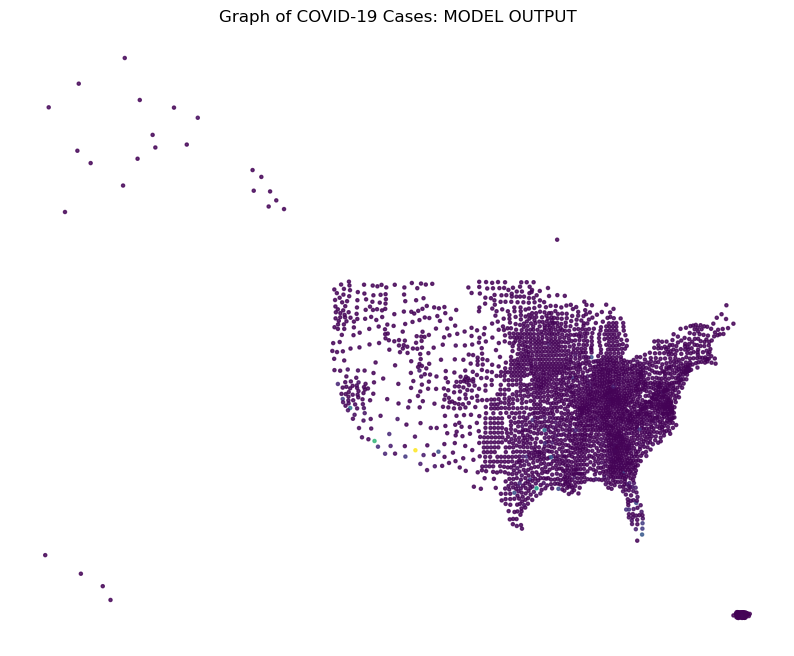

In [322]:
print(out) # last test output
print(target_graph_signal) # last test example

# plot the united states and have these values as the nodes

# get a list of the key values in train_graph_sig
geoid_list = list(train_graph_sig.keys())

# make a dictionary where key is geoid_list entry and value is out entry
out_dict = {geoid_list[i]: out[i].item() for i in range(len(out))}
target_dict = {geoid_list[i]: target_graph_signal[i].item() for i in range(len(target_graph_signal))}

# need to get the geographical information on where to put these nodes
# get the geographical information from the preprocessor, 'geoid_o', 'lat_o', 'lng_o' for all the geoids in out_dict
print(graph_kronecker_whole_df)

# for each geoid_o which is a key in out_dict, get the lat_o and lng_o from the graph_kronecker_whole_df
# then plot the united states and put the values of out_dict as the node values (new_confirmed)
# then compare with the target_dict values

import networkx as nx
import matplotlib.pyplot as plt

# Create an empty graph
G = nx.Graph()

# Add nodes with attributes
geoid_o = list(out_dict.keys())
lat_o = [graph_kronecker_whole_df[graph_kronecker_whole_df['geoid_o'] == key]['lat_o'].values[0] for key in out_dict.keys()]
lng_o = [graph_kronecker_whole_df[graph_kronecker_whole_df['geoid_o'] == key]['lng_o'].values[0] for key in out_dict.keys()]
new_confirmed = [out_dict[key] for key in out_dict.keys()]
for i in range(len(geoid_o)):
    G.add_node(geoid_o[i], new_confirmed=new_confirmed[i], lat=lat_o[i], lng=lng_o[i])

# Get node positions
pos = {node: (G.nodes[node]['lng'], G.nodes[node]['lat']) for node in G.nodes}

# Get node values
node_values = [G.nodes[node]['new_confirmed'] for node in G.nodes]

# Plot the graph
plt.figure(figsize=(10, 8))
nx.draw_networkx(G, pos, node_color=node_values, cmap='viridis', node_size=5, alpha=0.8, with_labels=False)
# plt.colorbar(label='New Confirmed Cases')
plt.title('Graph of COVID-19 Cases: MODEL OUTPUT')
plt.axis('off')
plt.show()



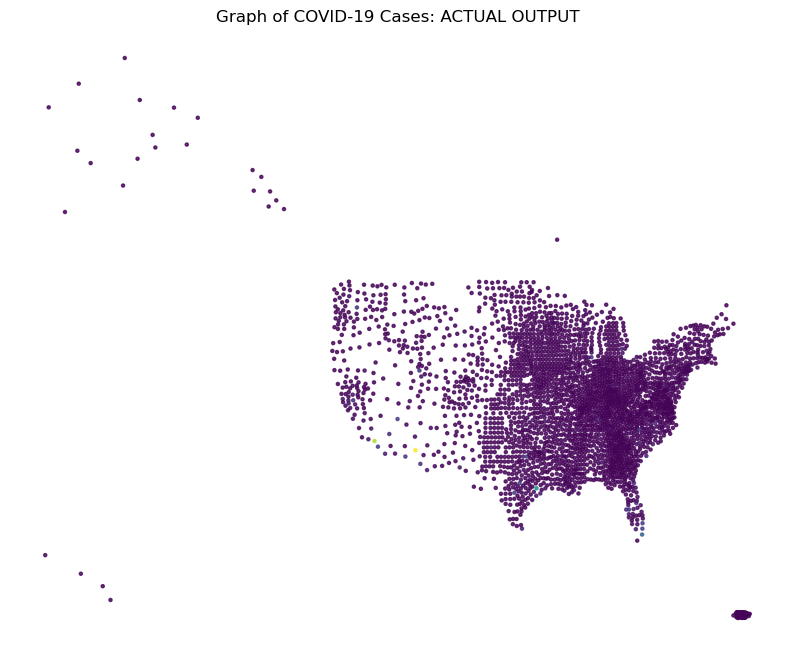

In [323]:
# Create an empty graph
H = nx.Graph()

# Add nodes with attributes
geoid_o = list(target_dict.keys())
lat_o = [graph_kronecker_whole_df[graph_kronecker_whole_df['geoid_o'] == key]['lat_o'].values[0] for key in target_dict.keys()]
lng_o = [graph_kronecker_whole_df[graph_kronecker_whole_df['geoid_o'] == key]['lng_o'].values[0] for key in target_dict.keys()]
new_confirmed = [target_dict[key] for key in target_dict.keys()]
for i in range(len(geoid_o)):
    H.add_node(geoid_o[i], new_confirmed=new_confirmed[i], lat=lat_o[i], lng=lng_o[i])

# Get node positions
pos = {node: (H.nodes[node]['lng'], H.nodes[node]['lat']) for node in H.nodes}

# Get node values
node_values = [H.nodes[node]['new_confirmed'] for node in H.nodes]

# Plot the graph
plt.figure(figsize=(10, 8))
nx.draw_networkx(H, pos, node_color=node_values, cmap='viridis', node_size=5, alpha=0.8, with_labels=False)
# plt.colorbar(label='New Confirmed Cases')
plt.title('Graph of COVID-19 Cases: ACTUAL OUTPUT')
plt.axis('off')
plt.show()